The objectives of this jupyter notebook are to generate random structures of Chabazite with different Al ratios, and count specific Al-Al pairs during Cu titration.

The general procedures to achieve these objectives are as below.

1. Given lattice parameters, identify all the distinct cluster types.  

2. Given structure dimensions, figure out the coordinates for all the sites in a structure.  
   lattice parameter + atom location + structure dimension -> coordinates for all the sites within one structure cell. 
   
2. Generate cluster list.  
   ATAT corrdump can go through all the clusters in one structure cell for each cluster type. In this process, we can generate a cluster list having the site coordinates (site indices) for all the clusters.  
   
3. Figure out good/bad pair sites for each site.  
   Identify good/bad cluster types and then add good/bad pair sites for each site.  
   
4. Generate random structures.  
   Repeat as following: randomly select one site from the available site list, remove the selected site and its bad pair sites from the available site list.  
   
5. Copper titration.   
   Create existing good cluster list: only keep existing good Al-Al clusters based on Al positions.   
   Repeat as follwoing: randomly select an exsiting good cluster, record the type of the selected cluster, remove the relevant clusters (sharing sites with the selected clusteres) from the list.  

The codes have 14 sections.  
1. Modification of ATAT  
2. Prepare lattice input file (lat.in)  
3. Read lattice input file (lat.in)  
4. Functions to convert between fractional coordinates and xyz coordinates  
5. Prepare structure requirements input file (str_req.txt)  
6. Read structure requirements input file (str_req.txt)  
7. Function to find the site index for any given fractional coordinates  
8. Create str.out file  
9. Run corrdump to generate cluster list into cluster_list.csv file  
10. Read cluster_list.csv  
11. Add pair sites for each site in structure sites dataframe  
12. Randomly generate structure for any given Si/Al ratio  
13. Count clusters during copper titration  
14. Cu/Al for different Si/Al ratios  

#### 1. Modification of ATAT

Before we run the codes, we have to modify ATAT files to output the cluster list when we run corrdump to count clusters. Corrdump has many parameters. Here we will only set the maximum distance between two points within a pair (-2=[real]), with other parameters being default. The modification of ATAT contains 2 parts: one is in calccorr.c++ file and the other is in corrdump.c++ file. After the modifications, **corrdump will output the xyz coordinates for all the clusters in a structure inspite of the atom occupations.**

Note: If you also want to set other parameters, you may need to make more modifications.

a) In file calccorr.c++, please modify the following function (around line 200) as below. The modified lines have comments at the end.

b) In file corrdump.c++, please modify the following code block (around line 460). The modified lines have comments at the end.

c) After you modify the ATAT codes, you have to reinstall the ATAT **in terminal**. It should contain the following two commands.

Python codes start here

In [1]:
import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
%matplotlib inline

#### 2. Prepare lattice input file (lat.in)

The input file of lat.in contains the lattice parameters and all the possible types of atoms at each site. The detailed format of lat.in can be found in the ATAT manual (https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/manual.pdf) pg. 36.  
 
The following information is from ATAT manual.  
Lattice file format:  
First, the coordinate system a,b,c is specified, either as  
[a] [b] [c] [alpha] [beta] [gamma]  

Then the lattice vectors u,v,w are listed, expressed in the coordinate system   just defined:  
[ua] [ub] [uc]  
[va] [vb] [vc]  
[wa] [wb] [wc]  

Finally, atom positions and types are given, expressed in the same coordinate system   as the lattice vectors:  
[atom1a] [atom1b] [atom1c] [atom1type]  
[atom2a] [atom2b] [atom2c] [atom2type]  
etc.  

In the lattice file:  
-The atom type is a comma-separated list of the atomic  
symbols of the atoms that can sit the lattice site.  
-In a binary, the first symbol listed is assigned a spin of -1.  
In general, ordering of the atom symbol corresponds to value of s=0,1,... in the table  
’Convention used to calculate the correlations’ below.  
-When only one symbol is listed, this site is ignored for the purpose  
of calculating correlations, but not for determining symmetry.  
-The atomic symbol ’Vac’ or ’Va’ is used to indicate a vacancy.  

#### 3. Read lattice input file (lat.in)
Read lat.in file and create a lattice dictionary which contains the lattice parameters, lattice vectors and fractional coordinates of all the sites in the lattics.

In [2]:
filepath='lat.in'
file = open(filepath, 'r')
lat = file.readlines()

lattice = {}
lattice['a'], lattice['b'], lattice['c'], lattice['alpha'], lattice['beta'], lattice['gamma'] = [float(number) for number in lat[0].split()]
lattice['u'] = [int(number) for number in lat[1].split()]
lattice['v'] = [int(number) for number in lat[2].split()]
lattice['w'] = [int(number) for number in lat[3].split()]

lattice_sites = pd.DataFrame(columns=['a', 'b', 'c', 'atom'])
for line in lat[4:]:
    site = line.split()[:3]
    atom_type = ''
    for atom in line.split()[3:]:
        atom_type += str(atom)
    site.append(atom_type)
    lattice_sites = lattice_sites.append(pd.DataFrame([site], columns=['a', 'b', 'c', 'atom']))
lattice_sites = lattice_sites.apply(pd.to_numeric, errors = 'ignore')

In [3]:
lattice

{'a': 13.675,
 'alpha': 90.0,
 'b': 13.675,
 'beta': 90.0,
 'c': 14.767,
 'gamma': 120.0,
 'u': [1, 0, 0],
 'v': [0, 1, 0],
 'w': [0, 0, 1]}

In [4]:
lattice_sites.head()

,a,b,c,atom
0,0.666967,0.106933,0.228233,"Si,Al"
0,0.893067,0.560033,0.228233,"Si,Al"
0,0.666967,0.560033,0.228233,"Si,Al"
0,0.439967,0.333033,0.228233,"Si,Al"
0,0.568667,0.137333,0.456033,O


#### 4. Functions to convert between fractional coordinates and xyz coordinates

In [5]:
def lattice_axes_xyz(lattic):
    '''
    function to prepare the xyz axes (a matrix)
                [ax] [ay] [az]
    axes_xyz =  [bx] [by] [bz]
                [cx] [cy] [cz]
    '''
    a = np.array([1,0,0]) * lattice['a']
    b = np.array([cos(lattice['gamma']/180*pi), sin(lattice['gamma']/180*pi), 0]) * lattice['b']
    c = np.cross(a, b)/np.linalg.norm(np.cross(a, b)) * lattice['c']
    return np.array((a,b,c))

In [6]:
def lattice_axes_abc(lattice):
    '''
    function to prepare the abc axes (a matrix)
                [ua] [ub] [uc]
    axes_abc =  [va] [vb] [vc]
                [wa] [wb] [wc]
    '''
    return np.array((lattice['u'], lattice['v'], lattice['w']))

In [7]:
def frac_to_xyz(axes_xyz, frac_coor):
    '''
    function to convert fractional coordinates to xyz coordinates
    '''
    return np.dot(frac_coor, axes_xyz)

In [8]:
def xyz_to_frac(axes_xyz, xyz_coor):
    '''
    function to convert xyz coordinates to fractional coordinates
    '''
    return np.dot(xyz_coor, np.linalg.inv(axes_xyz))

In [9]:
axes_abc = lattice_axes_abc(lattice)

In [10]:
axes_abc

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [11]:
axes_xyz = lattice_axes_xyz(lattice)

In [12]:
axes_xyz

array([[ 13.675    ,   0.       ,   0.       ],
       [ -6.8375   ,  11.8428974,   0.       ],
       [  0.       ,  -0.       ,  14.767    ]])

In [13]:
frac_to_xyz(axes_xyz, np.array((0.5, 0.5, 0)))

array([ 3.41875  ,  5.9214487,  0.       ])

In [14]:
xyz_to_frac(axes_xyz, np.array((6.8375, 0, 0)))

array([ 0.5,  0. ,  0. ])

#### 5. Prepare structure requirements input file (str_req.txt)
Before creating str_req.txt, we have to know all the cluster types within the maximum distance that we specified. We can run corrdump with only the lat.in file. A clusters.out file will be generated. It contains the information of all the symmetrically distinct clusters for the lattice that you specified in lat.in file. Based on the cluster order in the clusters.out file and the number of atoms(sites) containing in the cluster, we will define the cluster type as: 

cluster type = [nsite]-[order of the specific cluster in all nsite-clusters in clusters.out].

For example, for the first 2-body cluster in clusters.out, its cluster type is 2-1.  
For the second 2-body cluster in clusters.out, its cluster type is 2-2.

Then we will create a file which describe the structure requirements. It will include 3 parts: 1) the structure dimensions, 2) the clusters that cannot exist based on the rules we defined (*bad clusters*), and 3) the clusters of interest (*good clusters*, we want to count the number of them).  

The specific str_req.txt format:

First the structure vectors u,v,w are listed, expressed in the coordinate system just defined:  
[ua] [ub] [uc]  
[va] [vb] [vc]  
[wa] [wb] [wc]  

Next, the cluster types that cannot exist:  
[badtype1] [badtype2] [badtype3] [badtype4] etc.  

Finally, the cluster types of interest:  
[goodtype1] [goodtype2] [goodtype3] [goodtype4] etc.  

Here is an example of str_req.txt file.

2 0 0  
0 2 0  
0 0 2   
2-1, 2-2, 2-3, 2-4  
2-5, 2-6, 2-7, 2-8, 2-9, 2-10, 2-11  

#### 6. Read structure requirements input file (str_req.txt)
Generate structure dictionary containing structure dimensions, site coordinates, bad clusters (cannot exist) and good clusters (we want to count).

In [15]:
structure = {}

In [16]:
file = open('str_req.txt', 'r')
str_req = file.readlines()

structure_u = [int(number) for number in str_req[0].split()]
structure_v = [int(number) for number in str_req[1].split()]
structure_w = [int(number) for number in str_req[2].split()]

bad_types = [s.replace(' ', '').replace('\n', '') for s in str_req[3].split(',')]
good_types = [s.replace(' ', '').replace('\n', '') for s in str_req[4].split(',')]

In [17]:
structure_u

[2, 0, 0]

In [18]:
bad_types

['2-1', '2-2', '2-3', '2-4']

In [19]:
nu = int(np.mean(structure_u)/np.mean(lattice['u']))
nv = int(np.mean(structure_v)/np.mean(lattice['v']))
nw = int(np.mean(structure_w)/np.mean(lattice['w']))
n_cell = nu * nv * nw

In [20]:
nu

2

In [107]:
O_unit_sites = lattice_sites[lattice_sites['atom']=='O']
O_sites = pd.DataFrame(columns=lattice_sites.columns)
for i in range(0, nu):
    for j in range(0, nv):
        for k in range(0, nw):
            sites = pd.DataFrame(columns=O_unit_sites.columns)
            delta = list(np.array(lattice['u'])*i + np.array(lattice['v'])*j + np.array(lattice['w'])*k)
            sites['a'] = O_unit_sites.a + delta[0]
            sites['b'] = O_unit_sites.b + delta[1]
            sites['c'] = O_unit_sites.c + delta[2]
            sites['atom'] = O_unit_sites.atom
            O_sites = O_sites.append(sites)

In [21]:
important_unit_sites =  lattice_sites[lattice_sites['atom']!='O']
structure_sites = pd.DataFrame(columns=lattice_sites.columns)
for i in range(0, nu):
    for j in range(0, nv):
        for k in range(0, nw):
            sites = pd.DataFrame(columns=important_unit_sites.columns)
            delta = list(np.array(lattice['u'])*i + np.array(lattice['v'])*j + np.array(lattice['w'])*k)
            sites['a'] = important_unit_sites.a + delta[0]
            sites['b'] = important_unit_sites.b + delta[1]
            sites['c'] = important_unit_sites.c + delta[2]
            sites['atom'] = important_unit_sites.atom
            structure_sites = structure_sites.append(sites)

In [22]:
structure_sites.reset_index(drop=True, inplace=True)
structure_sites['site_index'] = structure_sites.index

In [23]:
structure_sites.head(5)

,a,b,c,atom,site_index
0,0.666967,0.106933,0.228233,"Si,Al",0
1,0.893067,0.560033,0.228233,"Si,Al",1
2,0.666967,0.560033,0.228233,"Si,Al",2
3,0.439967,0.333033,0.228233,"Si,Al",3
4,0.666367,0.106633,0.438433,"Si,Al",4


In [24]:
structure['u'] = structure_u
structure['v'] = structure_v
structure['w'] = structure_w
structure['nu'] = nu
structure['nv'] = nv
structure['nw'] = nw
structure['sites'] = structure_sites
structure['good_types'] = good_types
structure['bad_types'] = bad_types

#### 7. Function to find the site index for any given fractional coordinates

In [25]:
def find_site_index(axes_abc, structure, frac_coor):
    df = structure['sites']
    nu, nv, nw = structure['nu'],structure['nv'],structure['nw']
    
    fu, fv, fw = np.dot(frac_coor, np.linalg.inv(axes_abc))
    
    #translate the site into the structure by subtracting multiple structure vector on each dimension
    fu -= (fu//nu)*nu
    fv -= (fv//nv)*nv
    fw -= (fw//nw)*nw
    
    fa, fb, fc = np.dot(np.array((fu, fv, fw)), axes_abc)
    
    site_index = df[(abs(df.a-fa) < 0.001) & (abs(df.b-fb) < 0.001) & (abs(df.c-fc) < 0.001)].index
    if len(site_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(site_index) < 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return site_index[0]

In [26]:
find_site_index(axes_abc, structure, [ -3.00016543e-04,   7.73299784e-01,   1.10509988e+00])

187

In [27]:
frac_coor = xyz_to_frac(axes_xyz, [16.77308,7.89881,11.39667])

In [28]:
find_site_index(axes_abc, structure, frac_coor)

176

#### 8. Create str.out file  
A str.out file is created based on the structure dimensions with Si on all sites. Actually the coordinates of all the clusters(cluster list) won't change in regards to the atom type on each site. Here we just put Si on all sites. 

In [29]:
if os.path.isfile('str.out'):
    os.remove('str.out')
with open('str.out', 'a') as str_file:
    str_file.write('{} {} {} {} {} {}\n'.format(lattice['a'], lattice['b'], lattice['c'], int(lattice['alpha']), int(lattice['beta']), int(lattice['gamma'])))
    str_file.write('{} {} {}\n'.format(int(structure['u'][0]),int(structure['u'][1]),int(structure['u'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['v'][0]),int(structure['v'][1]),int(structure['v'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['w'][0]),int(structure['w'][1]),int(structure['w'][2])))
    for index, row in structure['sites'].iterrows():
        str_file.write('{} {} {} Si\n'.format(row.a, row.b, row.c))

#### 9. Run corrdump to generate cluster list into cluster_list.csv file  
The cluster list contains the coordinates of all the clusters.

In [30]:
# Here we define the maximum distance between 2 atoms in a 2-body cluster is 6.2.
if os.path.isfile('cluster_list.csv'):
    os.remove('cluster_list.csv')
!corrdump -2 = 6.3 >> cluster_list.csv

#### 10. Read cluster_list.csv

The format for the file cluster_list.csv is as below.  
For each cluster type:  
First, the number of site in the cluster is given:  
[nsite]  
  
Next, the multiplicity (number of the cluster in the unit cell) is given:    
[multiplicity]  

Then, site xyz coordinates are listed for each cluster of that type:  
[cluster1site1x] [cluster1site1y] [cluster1site1z]  
[cluster1site2x] [cluster1site2y] [cluster1site2z]   
...  
[cluster1siteNx] [cluster1siteNy] [cluster1siteNz]  
[cluster2site1x] [cluster2site1y] [cluster2site1z]  
[cluster2site2x] [cluster2site2y] [cluster2site2z]   
...  
[cluster2siteNx] [cluster2siteNy] [cluster2siteNz]  
...  
...  
etc.  

Finally, the correlation function is given:  
[correlation function]  

Since all sites have Si in str.out, the correlation function is usually 0 or 1(for the first cluster type).

In [31]:
ncell = structure['nu']*structure['nv']*structure['nw']

In [32]:
clulist = []

with open('cluster_list.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=' ')
    for row in readCSV:
        if(len(row) == 0):
            continue
        elif(len(row) == 1):
            row[0] = row[0].replace('\t', '')
            clulist.append(int(float(row[0])))
        else:
            temp = []
            for element in row:
                temp.append(float(element))
            clulist.append(temp)

Create a dictionary (called clusters) which contains 1) cluster types, 2) cluster type number for different number of sites, and 3) the site indices for all the clusters for each cluster type.  

clusters['types'] will list all the cluster types.  
clusters['nsite_type_numbers'] will list the number of the types for nsite.  
clusters['2-1'] will list all the clusters (consist of site indices) of type 2-1.  

In [33]:
clusters = {}
nsite_type_numbers = {}
cluster_types = []

i = 0
nsite = 0
cluster_index = 1
temp = set()

while(i < len(clulist)):
    #read n_site
    new_nsite = clulist[i]
    i += 1
    
    #pass first three lines where the cluster contains 0 site
    if (new_nsite == 0):
        i+=2
        continue
    
    #if the cluster has more sites than the previous cluster, reset nsite and cluster index
    if (new_nsite != nsite):
        nsite = new_nsite
        cluster_index = 1
        
    #set the cluster type = [nsite]-[order of the specific cluster in all nsite-clusters].
    cluster_type = str(nsite)+'-'+str(cluster_index)
    cluster_types.append(cluster_type)
    
    #initialize a empty set called temp 
    temp = set()
        
    #read multiplicity
    multiplicity = clulist[i]
    i += 1
    
    #go through all the clusters
    n_cluster = multiplicity *ncell
    for j in range(n_cluster):
        cluster = set()
        for k in range(nsite):
            point = []
            for element in clulist[i]:
                point.append(float(element))
            frac_coor = xyz_to_frac(axes_xyz, point)
            site = find_site_index(axes_abc, structure, frac_coor)

            cluster.update([site])
            i += 1
        if frozenset(cluster) in temp:
            print('Error! Repeated cluster found in line {}. The cluster is {}.'.format(i+1, cluster))
        temp.add(frozenset(cluster))
    
    #pass the line with correlation
    i += 1 
    
    #put the set of clusters in dictionary of clusters
    clusters[cluster_type] = temp
    nsite_type_numbers[str(nsite)] = cluster_index
    
    #count cluster types
    cluster_index += 1   

clusters['cluster_types'] = cluster_types
clusters['nsite_type_numbers'] = nsite_type_numbers

In [34]:
clusters['cluster_types']

['1-1',
 '2-1',
 '2-2',
 '2-3',
 '2-4',
 '2-5',
 '2-6',
 '2-7',
 '2-8',
 '2-9',
 '2-10',
 '2-11',
 '2-12']

In [35]:
clusters['nsite_type_numbers']

{'1': 1, '2': 12}

#### 11. Add pair sites for each site in structure sites dataframe 

In [36]:
structure_sites.head()

,a,b,c,atom,site_index
0,0.666967,0.106933,0.228233,"Si,Al",0
1,0.893067,0.560033,0.228233,"Si,Al",1
2,0.666967,0.560033,0.228233,"Si,Al",2
3,0.439967,0.333033,0.228233,"Si,Al",3
4,0.666367,0.106633,0.438433,"Si,Al",4


In [37]:
#create a column for single-site cluster type
structure_sites['1'] = np.nan
#create one column for each multiple-site cluster
for nsite, clu_index in clusters['nsite_type_numbers'].items():
    if (nsite != '1'):
        for index in range(1, clu_index+1):
            clu_type = str(nsite)+'-'+str(index)
            structure_sites[clu_type] = ""
            structure_sites[clu_type].astype('object')

In [38]:
structure_sites.head()

,a,b,c,atom,site_index,1,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10,2-11,2-12
0,0.666967,0.106933,0.228233,"Si,Al",0,NaN,,,,,,,,,,,,
1,0.893067,0.560033,0.228233,"Si,Al",1,NaN,,,,,,,,,,,,
2,0.666967,0.560033,0.228233,"Si,Al",2,NaN,,,,,,,,,,,,
3,0.439967,0.333033,0.228233,"Si,Al",3,NaN,,,,,,,,,,,,
4,0.666367,0.106633,0.438433,"Si,Al",4,NaN,,,,,,,,,,,,


In [39]:
for nsite, clu_index in clusters['nsite_type_numbers'].items():
    for index in range(1, clu_index+1):
        clu_type = str(nsite)+'-'+str(index)
        if nsite == '1':
            for sites in clusters[clu_type]:
                for site in sites:
                    structure_sites.set_value(site, '1', int(index))
        else:
            for sites in clusters[clu_type]:
                for site in sites:
                    if (structure_sites.iloc[site][clu_type] == ''):
                        structure_sites.set_value(site, clu_type, set(sites.difference([site])))
                    else:
                        structure_sites.iloc[site][clu_type].update(set(sites.difference([site])))

In [40]:
structure_sites['1'] = structure_sites['1'].astype(int)

In [41]:
structure_sites.head()

,a,b,c,atom,site_index,1,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10,2-11,2-12
0,0.666967,0.106933,0.228233,"Si,Al",0,1,{13},{4},{28},{18},"{22, 31}",{25},"{1, 3}","{89, 132}","{93, 30}",{34},{2},{19}
1,0.893067,0.560033,0.228233,"Si,Al",1,1,{2},{34},{13},{7},"{16, 31}",{21},"{0, 3}","{170, 186}","{25, 246}",{19},{28},{4}
2,0.666967,0.560033,0.228233,"Si,Al",2,1,{1},{16},{3},{21},"{34, 19}",{7},"{28, 13}","{14, 63}","{33, 90}",{31},{0},{22}
3,0.439967,0.333033,0.228233,"Si,Al",3,1,{28},{19},{2},{33},"{16, 22}",{30},"{0, 1}","{8, 51}","{169, 21}",{4},{13},{34}
4,0.666367,0.106633,0.438433,"Si,Al",4,1,{22},{0},{31},{89},"{28, 13}",{83},"{34, 19}","{18, 107}","{173, 86}",{3},{16},{1}


Create column of good sites and bad sites in structure_sites dataframe

In [42]:
structure_sites['bad_sites'] = structure_sites.apply(lambda row: reduce((lambda x, y: set.union(x,row[y])), structure['bad_types'], set()), axis = 1)

In [43]:
structure_sites['good_sites'] = structure_sites.apply(lambda row: reduce((lambda x, y: set.union(x,row[y])), structure['good_types'], set()), axis = 1)

In [44]:
structure_sites.head()

,a,b,c,atom,site_index,1,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10,2-11,2-12,bad_sites,good_sites
0,0.666967,0.106933,0.228233,"Si,Al",0,1,{13},{4},{28},{18},"{22, 31}",{25},"{1, 3}","{89, 132}","{93, 30}",{34},{2},{19},"{28, 18, 4, 13}","{1, 2, 3}"
1,0.893067,0.560033,0.228233,"Si,Al",1,1,{2},{34},{13},{7},"{16, 31}",{21},"{0, 3}","{170, 186}","{25, 246}",{19},{28},{4},"{2, 34, 13, 7}","{0, 3, 28}"
2,0.666967,0.560033,0.228233,"Si,Al",2,1,{1},{16},{3},{21},"{34, 19}",{7},"{28, 13}","{14, 63}","{33, 90}",{31},{0},{22},"{16, 1, 3, 21}","{0, 28, 13}"
3,0.439967,0.333033,0.228233,"Si,Al",3,1,{28},{19},{2},{33},"{16, 22}",{30},"{0, 1}","{8, 51}","{169, 21}",{4},{13},{34},"{33, 2, 19, 28}","{0, 1, 13}"
4,0.666367,0.106633,0.438433,"Si,Al",4,1,{22},{0},{31},{89},"{28, 13}",{83},"{34, 19}","{18, 107}","{173, 86}",{3},{16},{1},"{0, 89, 22, 31}","{16, 34, 19}"


#### 12. Randomly generate structure for any given Si/Al ratio

In [82]:
Si_Al_ratio = 10

In [83]:
Al_conc = 1/(1+Si_Al_ratio)

In [84]:
available_sites = set(structure_sites.site_index)
structure_vector = np.zeros((len(available_sites), 1))
Al_number = int(Al_conc*len(available_sites))
selected_sites = []
Al_count = 0
while((Al_count < Al_number) & (len(available_sites) > 0)):
    #random select one site from all the available sites
    site = random.sample(available_sites, 1)[0]
    
    #add selected site to the list
    selected_sites.append(site)
    
    #find out the bad sites for the selected site
    bad_sites = structure_sites.iloc[site]['bad_sites']
    
    #remove the selected site and the coresponding bad sites from available sites
    available_sites.remove(site)
    available_sites = available_sites.difference(bad_sites)
    
    Al_count += 1
if(len(selected_sites) == Al_number):
    print(selected_sites)
else:
    print('Failed')
structure_vector[selected_sites] = 1

[96, 228, 126, 231, 143, 162, 248, 45, 246, 232, 49, 212, 183, 95, 281, 270, 16, 21, 167, 76, 25, 44, 109, 66, 264, 9]


In [108]:
all_sites = structure_sites.append(O_sites)[['a', 'b', 'c', 'site_index', 'atom']]

In [109]:
all_sites['x'] = all_sites.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[0], axis=1)
all_sites['y'] = all_sites.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[1], axis=1)
all_sites['z'] = all_sites.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[2], axis=1)

In [110]:
all_sites.head()

,a,b,c,site_index,atom,x,y,z
0,0.666967,0.106933,0.228233,0.0,"Si,Al",8.389619,1.266397,3.370317
1,0.893067,0.560033,0.228233,1.0,"Si,Al",8.383466,6.632413,3.370317
2,0.666967,0.560033,0.228233,2.0,"Si,Al",5.291548,6.632413,3.370317
3,0.439967,0.333033,0.228233,3.0,"Si,Al",3.739436,3.944076,3.370317
4,0.666367,0.106633,0.438433,4.0,"Si,Al",8.383466,1.262844,6.474340


In [111]:
if os.path.isfile('random_structure.xyz'):
    os.remove('random_structure.xyz')
with open('random_structure.xyz', 'a') as file:
    file.write('{}\n'.format(len(all_sites.index)))
    file.write('\n')
    for index, row in all_sites.iterrows():
        if isnan(row.site_index):
            file.write('O {} {} {}\n'.format(row.x, row.y, row.z))
        elif structure_vector[int(row.site_index)] == 0:
            file.write('Si {} {} {}\n'.format(row.x, row.y, row.z))
        else:
            file.write('Al {} {} {}\n'.format(row.x, row.y, row.z))


#### 13. Count clusters during copper titration

Create a dictionary includes all the clusters and their corresponding type

In [48]:
cluster_type_dict = {}
for cluster_type, cluster_sets in clusters.items():
    for cluster in cluster_sets:
        cluster_type_dict[cluster] = cluster_type

Create a set contains all good clusters

In [49]:
#all the clusters of interest
all_good_clusters = reduce((lambda x, y: set.union(x,clusters[y])), structure['good_types'], set())

In [50]:
len(all_good_clusters)

432

Create a set contains only existing good clusters

In [51]:
available_good_clusters = set()
for cluster in all_good_clusters:
    exist = 1
    for site in cluster:
        if structure_vector[site] == 0:
            exist = 0
            break
    if exist == 1:
        available_good_clusters.add(cluster)

In [52]:
len(available_good_clusters)

4

Copper titration

In [53]:
copper_count = 0
selected_clusters = set()
while(len(available_good_clusters)>0):
    #randomly select a cluster from the clusters of interest
    cluster = random.sample(available_good_clusters, 1)[0]
    
    #add selected clusters to list
    selected_clusters.add(cluster)
    
    #remove selected clusters from the clusters of interest
    available_good_clusters.remove(cluster)
    
    #remove other clusters that share elements with the selected cluster
    for site in cluster:
        for pair_site in structure_sites.iloc[site].good_sites:
            relevant_cluster = frozenset([site, pair_site])
            if relevant_cluster in available_good_clusters:
                available_good_clusters.remove(relevant_cluster)

    copper_count += 1

In [54]:
copper_count

4

In [55]:
selected_clusters

{frozenset({6, 168}),
 frozenset({83, 86}),
 frozenset({49, 64}),
 frozenset({224, 233})}

Count the clusters for each cluster type

In [56]:
cu_occupied_cluster_number = defaultdict(lambda: 0)
for cluster in selected_clusters:
    cluster_type = cluster_type_dict[cluster]
    cu_occupied_cluster_number[cluster_type] += 1

In [57]:
cu_occupied_cluster_number

defaultdict(<function __main__.<lambda>>, {'2-7': 4})

#### 14. Cu/Al for different Si/Al ratios

In [64]:
def titration(Si_Al_ratio, structure_number, titration_number, structure, clusters):
    all_good_clusters = reduce((lambda x, y: set.union(x,clusters[y])), structure['good_types'], set())
    
    Al_conc = 1/(1+Si_Al_ratio)
    Al_number = int(Al_conc*len(structure_sites.index))
    
    cu_occupied_clusters = defaultdict(lambda: [])
    
    s_count = 0
    failed_count = 0
    while(s_count < structure_number):
        available_sites = set(structure_sites.site_index)
        structure_vector = np.zeros((len(available_sites), 1))
        selected_sites = []
        Al_count = 0
        while((Al_count < Al_number) & (len(available_sites) > 0)):
            site = random.sample(available_sites, 1)[0]
            selected_sites.append(site)
            bad_sites = structure_sites.iloc[site]['bad_sites']
            available_sites.remove(site)
            available_sites = available_sites.difference(bad_sites)
            Al_count += 1
        if(len(selected_sites) != Al_number):
            failed_count += 1
            if failed_count > 100*structure_number:
                print('Error! Too hard to generate a random structure based on the Si/Al ratio.')
                return
            else:
                continue
        else:
            #start copper titration
            structure_vector[selected_sites] = 1
            s_count += 1
            
            available_good_clusters = set()
            for cluster in all_good_clusters:
                exist = 1
                for site in cluster:
                    if structure_vector[site] == 0:
                        exist = 0
                        break
                if exist == 1:
                    available_good_clusters.add(cluster)
            
            t_count = 0
            while(t_count < titration_number):
                copper_count = 0
                temp = defaultdict(lambda: 0)
                selected_clusters = set()
                new_good_clusters = deepcopy(available_good_clusters)
                while(len(new_good_clusters)>0):
                    cluster = random.sample(new_good_clusters, 1)[0]
                    selected_clusters.add(cluster)
                    new_good_clusters.remove(cluster)
                    for site in cluster:
                        for pair_site in structure_sites.iloc[site].good_sites:
                            relevant_cluster = frozenset([site, pair_site])
                            if relevant_cluster in new_good_clusters:
                                new_good_clusters.remove(relevant_cluster)
                    copper_count += 1
                
                t_count += 1    
                for cluster in selected_clusters:
                    cluster_type = cluster_type_dict[cluster]
                    temp[cluster_type] += 1
                cu_occupied_clusters['copper_count'].append(copper_count)
                for cluster_type in structure['good_types']:
                    cu_occupied_clusters[cluster_type].append(temp[cluster_type])
    
    for key, valuelist in cu_occupied_clusters.items():
        cu_occupied_clusters[key] = {}
        cu_occupied_clusters[key]['mean'] = np.mean(valuelist)
        cu_occupied_clusters[key]['std'] = np.std(valuelist)

    return cu_occupied_clusters

In [132]:
#Si/Al ratio = 3
start = timer()
cu_occupied_clusters= titration(3,500,100,structure,clusters)
end = timer()
print(end - start) 

523.794676013058


In [133]:
cu_occupied_clusters

defaultdict(<function __main__.titration.<locals>.<lambda>>,
            {'2-11': {'mean': 8.2639999999999993, 'std': 2.614250179305722},
             '2-7': {'mean': 16.655999999999999, 'std': 2.538831227159458},
             'copper_count': {'mean': 24.920000000000002,
              'std': 1.6702095676890372}})

In [135]:
cu_occupied_clusters['copper_count']['mean']/int(1/(1+3)*len(structure_sites.site_index))

0.34611111111111115

In [136]:
cu_occupied_clusters['copper_count']['std']/int(1/(1+3)*len(structure_sites.site_index))

0.023197355106792182

In [76]:
Si_Al_ratios = [2.5, 5, 7.5, 10, 15, 20, 25, 30, 35, 40]

columns = ['si_al', 'cu_al_mean', 'cu_al_std'] + reduce((lambda x, y: x+[y+'_mean', y+'_std']), structure['good_types'], [])
copper_titration = pd.DataFrame(columns=columns)
copper_titration['si_al'] = Si_Al_ratios
copper_titration.fillna(0, inplace=True)

In [77]:
copper_titration

,si_al,cu_al_mean,cu_al_std,2-7_mean,2-7_std,2-11_mean,2-11_std
0,2.5,0,0,0,0,0,0
1,5.0,0,0,0,0,0,0
2,7.5,0,0,0,0,0,0
3,10.0,0,0,0,0,0,0
4,15.0,0,0,0,0,0,0
5,20.0,0,0,0,0,0,0
6,25.0,0,0,0,0,0,0
7,30.0,0,0,0,0,0,0
8,35.0,0,0,0,0,0,0
9,40.0,0,0,0,0,0,0


In [78]:
start = timer()

for index, si_al in enumerate(Si_Al_ratios):
    print(si_al)
    Al_number = int(1/(1+si_al)*len(structure_sites.site_index))
    cu_occupied_clusters =  titration(si_al,500,100,structure,clusters)
    copper_titration.loc[index, 'cu_al_mean'] = cu_occupied_clusters['copper_count']['mean']/Al_number
    copper_titration.loc[index, 'cu_al_std'] = cu_occupied_clusters['copper_count']['std']/Al_number
    for clu_type in structure['good_types']:
        copper_titration.loc[index, clu_type+'_mean'] = cu_occupied_clusters[clu_type]['mean']/Al_number
        copper_titration.loc[index, clu_type+'_std'] = cu_occupied_clusters[clu_type]['std']/Al_number

end = timer()
print(end - start) 

2.5
5
7.5
10
15
20
25
30
35
40
1176.8631140079815


In [79]:
copper_titration

,si_al,cu_al_mean,cu_al_std,2-7_mean,2-7_std,2-11_mean,2-11_std
0,2.5,0.382000,0.019139,0.253463,0.032148,0.128537,0.036619
1,5.0,0.242750,0.035077,0.163000,0.040058,0.079750,0.036434
2,7.5,0.162121,0.047136,0.108242,0.044791,0.053879,0.037172
3,10.0,0.127615,0.051384,0.085000,0.047759,0.042615,0.037138
4,15.0,0.088333,0.056380,0.057444,0.049964,0.030889,0.040325
5,20.0,0.064923,0.060748,0.043846,0.051089,0.021077,0.038224
6,25.0,0.057818,0.064763,0.038182,0.053905,0.019636,0.040385
7,30.0,0.039778,0.063424,0.024889,0.053728,0.014889,0.039133
8,35.0,0.040250,0.065945,0.027500,0.057500,0.012750,0.039449
9,40.0,0.032000,0.064178,0.021429,0.052586,0.010571,0.039519


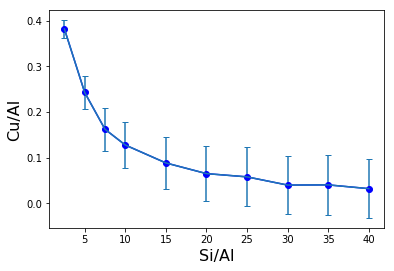

In [137]:
plt.plot(copper_titration.si_al, copper_titration.cu_al_mean,'bo-');
plt.xlabel('Si/Al', fontsize=16)
plt.ylabel('Cu/Al', fontsize=16)
plt.errorbar(copper_titration.si_al, copper_titration.cu_al_mean, yerr=copper_titration.cu_al_std,capsize=3);

In [81]:
#pickle.dump(copper_titration, open('copper_titration.pkl', 'wb'))